## Reading the secrets and importing the requirements

In [1]:
from secrets_import import * # check the secrets_import file for details

In [2]:
from config_setup_helper import * # check the config_setup file for details

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\shubh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
import time
from datetime import datetime,UTC
from bs4 import BeautifulSoup
import re
import pytesseract
from PIL import Image
import requests
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from gensim.models.doc2vec import Doc2Vec, TaggedDocument, Word2Vec
import pymysql
import numpy as np

## Scraping and cleaning helpers

In [4]:
# Load stopwords for keyword extraction
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Remove HTML, special characters, ads, and extra spaces."""
    if not text:
        return ""  # Handle empty text cases

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters, links, and promoted messages
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase

    # Mask usernames
    text = re.sub(r'u/[A-Za-z0-9_-]+', '[USERNAME]', text)

    # remove stopwords
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    return text

def extract_keywords(text):
    """Extract important keywords from the post content."""
    words = word_tokenize(text)
    keywords = [word for word in words if word.isalnum() and word not in stop_words]
    return ', '.join(set(keywords))  # Convert list to string for storage

def extract_text_from_images(image_url):
    """Extract text from images using OCR (Pytesseract)."""
    try:
        # Download the image (placeholder, needs proper downloading logic)
        requests.get(image_url, stream=True).raw
        image = Image.open(requests.get(image_url, stream=True).raw)  # This assumes the image is already downloaded
        text = pytesseract.image_to_string(image)
        return clean_text(text)
    except Exception as e:
        print(f"Could not process image {image_url}: {e}")
        return ""


## Code to pull and save the posts in DB

In [5]:
def fetch_and_store_reddit_posts(subreddit_name, n_posts):
    """Fetch, preprocess, and store Reddit posts while handling large requests."""
    setup_database()

    subreddit = reddit.subreddit(subreddit_name)
    batch_size = 1000  # Max Reddit API limit per request
    fetched_posts = 0
    conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, database = MYSQL_DB)
    cursor = conn.cursor()

    while fetched_posts < n_posts:
        limit = min(batch_size, n_posts - fetched_posts)

        print(f"Fetching {limit} posts...")

        try:
            for post in subreddit.hot(limit=limit):
                title = post.title
                content = clean_text(post.selftext)

                timestamp = datetime.fromtimestamp(post.created_utc, UTC)

                image_text = ""
                if hasattr(post, "preview") and "images" in post.preview:
                    image_url = post.preview["images"][0]["source"]["url"]
                    image_text = extract_text_from_images(image_url)


                if not content and not image_text:
                    continue

                keywords = extract_keywords(title+" "+content+" "+image_text)  # Extract keywords

                # Store in MySQL
                sql = "INSERT INTO posts (title, content, timestamp, subreddit, keywords, image_text) VALUES (%s, %s, %s, %s, %s, %s)"
                cursor.execute(sql, (title, content, timestamp, subreddit_name, keywords, image_text))

                fetched_posts += 1
                if fetched_posts >= n_posts:
                    break  # Stop when we reach desired count

            conn.commit()
            print(f"Stored {fetched_posts} posts so far.")

        except Exception as e:
            print(f"Error fetching posts: {e}")
            time.sleep(5)  # Retry after a short delay

        time.sleep(2)  # Avoid rate limits

    print(f"Successfully stored {fetched_posts} posts.")
    conn.close()

### Calling the function (run all above cells first)

In [ ]:
if __name__ == "__main__":
    fetch_and_store_reddit_posts("askscience", 20)

## Part A: Generating Embeddings

#### Using both doc2vec and word2 vec to generate 2 seperate embeddings

In [6]:
def get_all_posts():
    conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, db=MYSQL_DB)
    cursor = conn.cursor()
    cursor.execute("SELECT id, title, content, image_text FROM posts")
    posts =  cursor.fetchall()
    conn.close()
    return posts

### Embeddings based on Doc2Vec

In [28]:
def doc2Vec_embeddings(posts):
    tagged_data = [
        TaggedDocument(
            words=word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]]))),
            tags=[str(row[0])]
        )
        for row in posts
    ]

    model_doc = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=20)
    model_doc.build_vocab(tagged_data)

    model_doc.train(tagged_data, total_examples=model_doc.corpus_count, epochs=model_doc.epochs)

    vectors_doc = []
    for row in posts:
        vectors_doc.append(model_doc.infer_vector(word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]])))))

def doc2Vec_experiment(posts, vector_size, epochs, min_count):
    tagged_data = [
        TaggedDocument(
            words=word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]]))),
            tags=[str(row[0])]
        )
        for row in posts
    ]

    model_doc = Doc2Vec(vector_size=vector_size, window=5, min_count=min_count, workers=4, epochs=epochs)
    model_doc.build_vocab(tagged_data)

    model_doc.train(tagged_data, total_examples=model_doc.corpus_count, epochs=model_doc.epochs)

    return model_doc

posts = get_all_posts()

model1 = doc2Vec_experiment(posts, vector_size=50, epochs=20, min_count=2)
model2 = doc2Vec_experiment(posts, vector_size=100, epochs=30, min_count=5)
model3 = doc2Vec_experiment(posts, vector_size=200, epochs=40, min_count=10)

### Embeddings based on Word2Vec and Bag-of-Words

In [9]:
def word2Vec_embeddings(posts):
    tokenized_posts = [word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]]))) for row in posts]
    model = Word2Vec(sentences=tokenized_posts, vector_size=100, window=5, min_count=1, workers=4, epochs=20)

def word2vec_training(posts, vector_size=100):
    sentences = [word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]]))) for row in posts]
    model_word = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=2, workers=4)
    return model_word

model_word = word2vec_training(posts, vector_size=100)

In [24]:
from sklearn.cluster import KMeans

def cluster_words(model_word, k=10):
    word_vectors = model_word.wv.vectors
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(word_vectors.astype(np.float64))

    word_clusters = {word: kmeans.predict([model_word.wv[word]])[0] for word in model_word.wv.index_to_key}
    return word_clusters

word_bins = cluster_words(model_word, k=10)

## PartB: KMeans to cluster the data

In [36]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def cluster_documents(vectors, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(vectors)
    return labels

labels_doc2vec = cluster_documents([model1.infer_vector([str(x).lower() for x in doc[1:]]) for doc in posts])
labels_word2vec = cluster_documents([model_word.wv[doc[0]] for doc in posts if doc[0] in model_word.wv])

In [38]:
# Store cluster labels in MySQL
def store_cluster_labels(labeled_cluster_doc,labeled_cluster_word):
    conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, db=MYSQL_DB)
    cursor = conn.cursor()

    for i in range(len(labeled_cluster_doc)):
        post_id, cluster_id_doc = labeled_cluster_doc[i]
        post_id_word, cluster_id_word = labeled_cluster_word[i]

        if post_id != post_id_word:
            raise ValueError("Post IDs do not match between the two clustering results.")

        cursor.execute("UPDATE posts SET cluster_id_doc=%s, cluster_id=%s WHERE id=%s", (cluster_id_doc, cluster_id_word, post_id))

    conn.commit()
    conn.close()

store_cluster_labels(labels_doc2vec,labels_word2vec)

TypeError: cannot unpack non-iterable numpy.int32 object

In [ ]:
from collections import Counter

def get_all_posts():
    conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, db=MYSQL_DB)
    cursor = conn.cursor()
    cursor.execute("SELECT id, title, content, image_text,cluster_id,cluster_id_doc FROM posts")
    posts =  cursor.fetchall()
    conn.close()
    return posts


def organize_by_clusters(post):
    cluster_dict_word = {}
    cluster_dict_doc = {}
    for row in posts:
        cluster_id_word = row[-2]
        cluster_id_doc = row[-1]

        if cluster_id_word not in cluster_dict_word:
            cluster_dict_word[cluster_id_word] = []
        cluster_dict_word[cluster_id_word].append(row)

        if cluster_id_doc not in cluster_dict_doc:
            cluster_dict_doc[cluster_id_doc] = []
        cluster_dict_doc[cluster_id_doc].append(row)
    return cluster_dict_doc,cluster_dict_word

posts= get_all_posts()
cluster_dict_doc,cluster_dict_word = organize_by_clusters(posts)



def extract_keywords(texts):

    all_words = " ".join(texts)
    all_words = clean_text(all_words).split()
    word_counts = Counter(all_words)
    return ", ".join([word for word, _ in word_counts.most_common(10)])  # Top 5 keywords ## TODO: Change this strategy, remove stopword

cluster_keywords_word = {cluster_id: extract_keywords([row[1] +" "+ row[2] +" "+ row[3] for row in contents]) for cluster_id, contents in cluster_dict_word.items()}
cluster_keywords_doc = {cluster_id: extract_keywords([row[1] +" "+ row[2] +" "+ row[3] for row in contents]) for cluster_id, contents in cluster_dict_doc.items()}



In [ ]:
import pprint
print("Keywords by cluster using Word to vec")
pprint.pprint(cluster_keywords_word)
print("Keywords by cluster using Doc to vec")
pprint.pprint(cluster_keywords_doc)

Keywords by cluster using Word to vec
{0: 'amputated, happens, limb, gets, could, understand, people, got, leg, '
    'curious',
 1: 'get, rabies, oldest, could, species, permafrost, around, exposure, '
    'vaccines, years',
 2: 'field, panel, panelist, comments, askscience, application, please, post, '
    'one, expertise',
 3: 'would, core, ask, earth, understand, alleles, gene, know, life, like',
 4: 'cookware, would, water, small, pot, also, energy, steam, dinosaurs, '
    'survived'}
Keywords by cluster using Doc to vec
{0: 'life, earth, would, evolve, breathe, oxygen, air, nitrogen, core, metal',
 1: 'field, panel, panelist, comments, askscience, application, please, post, '
    'one, expertise',
 2: 'would, understand, alleles, gene, human, genes, foxp2, nf, 1, language',
 3: 'core, inner, cookware, get, rabies, know, could, water, also, small',
 4: 'ask, question, questions, anything, askscience, post, please, wednesday, '
    'r, answer'}


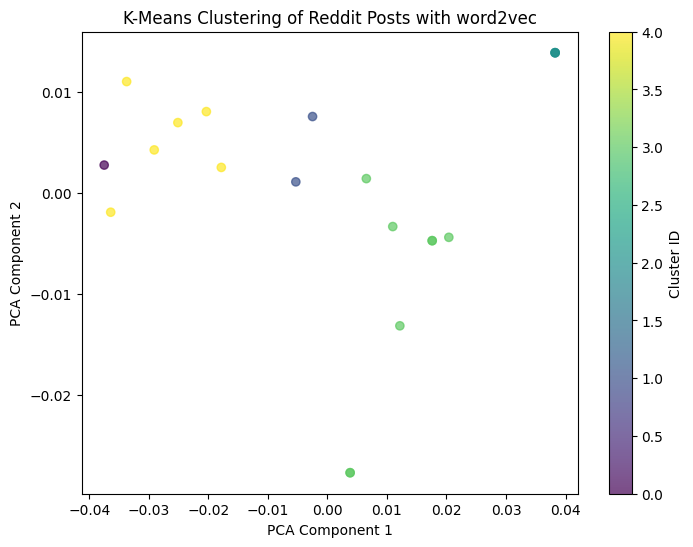

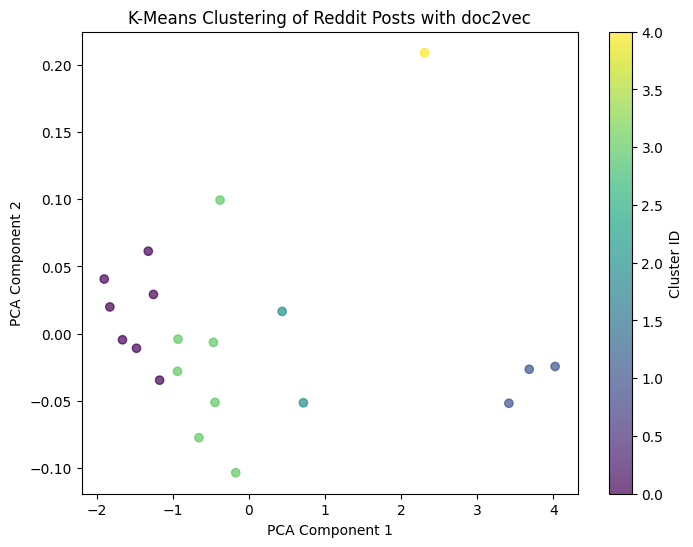

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_clusters(vectors, labels, title):
    pca = PCA(n_components=2)
    reduced_vectors = pca.fit_transform(vectors)

    plt.figure(figsize=(8,6))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label="Cluster ID")
    plt.show()

plot_clusters(vectors_doc, cluster_doc, "K-Means Clustering of Reddit Posts with Doc2Vec")
plot_clusters(vectors_word, cluster_word, "K-Means Clustering of Reddit Posts with Word2Vec")

In [ ]:
#  code to predict cluster of a new text with both methods
def predict_cluster(text, model_doc, model_word, kmeans_doc, kmeans_word):
    text = clean_text(text)

    # Infer vector using Doc2Vec model
    vector_doc = model_doc.infer_vector(word_tokenize(text))

    # Calculate mean vector using Word2Vec model
    word_vectors = [model_word.wv[word] for word in word_tokenize(text) if word in model_word.wv]
    if word_vectors:
        vector_word = np.mean(word_vectors, axis=0)
    else:
        vector_word = np.zeros(model_word.vector_size)

    # Ensure vectors are in the correct format and data type
    vector_doc = np.array(vector_doc, dtype=np.float32)
    vector_word = np.array(vector_word, dtype=np.float32)

    # Predict clusters
    cluster_doc = kmeans_doc.predict(vector_doc.reshape(1, -1))[0]
    cluster_word = kmeans_word.predict(vector_word.reshape(1, -1))[0]

    return cluster_doc, cluster_word

if __name__ == "__main__":

    text = "What is the difference between a virus and a bacteria?"
    print("\n")
    print(text)
    cluster_doc, cluster_word = predict_cluster(text, model_doc, model_word, kmeans_doc, kmeans_word)
    print(f"Predicted cluster (doc2vec): {cluster_doc}")
    print(f"Predicted cluster (word2vec): {cluster_word}")

    text2 = "Dinasours are very old"
    print("\n")

    print(text2)
    cluster_doc, cluster_word = predict_cluster(text2, model_doc, model_word, kmeans_doc, kmeans_word)
    print(f"Predicted cluster (doc2vec): {cluster_doc}")
    print(f"Predicted cluster (word2vec): {cluster_word}")



What is the difference between a virus and a bacteria?
Predicted cluster (doc2vec): 0
Predicted cluster (word2vec): 4


Dinasours are very old
Predicted cluster (doc2vec): 0
Predicted cluster (word2vec): 4


In [ ]:
def predict_similar_posts(text, model_doc, model_word, kmeans_doc, kmeans_word, posts):
    cluster_doc, cluster_word = predict_cluster(text, model_doc, model_word, kmeans_doc, kmeans_word)

    similar_posts_doc = [post for post in posts if post[-1] == cluster_doc]
    similar_posts_word = [post for post in posts if post[-2] == cluster_word]

    return similar_posts_doc, similar_posts_word

Evaluation metrics (quantitave and qualitative) to make comparisions:

NOTE: in report we should mention these below + manually inspect the clusters by checking if grouped documents are thematically similar and use that for the qualitative part too, and write an explanation of which method created more meaningful clusters.

Cluster Separation
Good clustering: Well-separated, distinct clusters with clear boundaries.
Poor clustering: Overlapping or mixed clusters (indicates embeddings may not capture differences well).
Cluster Shape & Compactness
Tightly packed clusters: Indicate strong embedding quality.
Scattered, stretched, or elongated clusters: Suggest embeddings may not be well-formed.
Outliers
Isolated points far from any cluster may indicate noisy or misclassified data.
Comparison Between Doc2Vec & Word2Vec
Which method produces better-separated clusters?
Does one have less overlap and more distinct groups?

In [ ]:
#quantitative: silhouette score
#measures how well samples are clustered (higher is better)

from sklearn.metrics import silhouette_score

# Silhouette Score for Doc2Vec clusters
doc2vec_silhouette = silhouette_score(vectors_doc, cluster_doc)
print(f"Silhouette Score for Doc2Vec: {doc2vec_silhouette:.4f}")

# Silhouette Score for Word2Vec clusters
word2vec_silhouette = silhouette_score(vectors_word, cluster_word)
print(f"Silhouette Score for Word2Vec: {word2vec_silhouette:.4f}")



#quantitative: Davies-Bouldin Index
#lowe bdi value means cluster better defined, high means more overlap

from sklearn.metrics import davies_bouldin_score

# Davies-Bouldin Index for Doc2Vec clusters
doc2vec_dbi = davies_bouldin_score(vectors_doc, cluster_doc)
print(f"Davies-Bouldin Index for Doc2Vec: {doc2vec_dbi:.4f}")

# Davies-Bouldin Index for Word2Vec clusters
word2vec_dbi = davies_bouldin_score(vectors_word, cluster_word)
print(f"Davies-Bouldin Index for Word2Vec: {word2vec_dbi:.4f}")



#PCA (Principal Component Analysis)
#helps visualize separation between clusters

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca(embeddings, labels, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label="Cluster")
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

# PCA Visualization for Doc2Vec
plot_pca(vectors_doc, cluster_doc, "PCA: Doc2Vec Clusters")
# PCA Visualization for Word2Vec
plot_pca(vectors_word, cluster_word, "PCA: Word2Vec Clusters")
#look at the separation, then this is qualitative


#t-SNE (t-Distributed Stochastic Neighbor Embedding)
#t-SNE helps visualize complex relationships in high-dimensional data
from sklearn.manifold import TSNE

def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced = tsne.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter, label="Cluster")
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()

# t-SNE Visualization for Doc2Vec
plot_tsne(doc2vec_vectors, doc2vec_clusters, "t-SNE: Doc2Vec Clusters")
# t-SNE Visualization for Word2Vec
plot_tsne(word2vec_vectors, word2vec_clusters, "t-SNE: Word2Vec Clusters")

